In [ ]:

import pandas as pd
import numpy as np
import datetime
from typing import Tuple
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ph1 = pd.read_csv('./csvs/400E_PH1.csv', sep='\\t', engine='python')
ph2 = pd.read_csv('./csvs/400E_PH2.csv', sep='\\t', engine='python')
temp1 = pd.read_csv('./csvs/400E_Temp1.csv', sep='\\t', engine='python')
temp2 = pd.read_csv('./csvs/400E_Temp2.csv', sep='\\t', engine='python')
binf =  pd.read_csv('./csvs/batch_info.csv', sep='\\t', engine='python')
bphase =  pd.read_csv('./csvs/batch_phase.csv', sep='\\t', engine='python')

### Don't mind this, just familirializing myself. Here for reference

In [ ]:
binf.head()

,StartDate,EndDate,BatchID
0,2022-04-02 00:00:26,2022-04-02 22:45:26,AP400E0101
1,2022-04-02 22:45:26,2022-04-03 02:03:26,None
2,2022-04-03 02:03:26,2022-04-04 00:55:26,TEST_001
3,2022-04-04 00:55:26,2022-04-04 04:12:26,None
4,2022-04-04 04:12:26,2022-04-05 02:09:26,AP400E0102


In [ ]:
bphase.head()

,StartDate,EndDate,BatchPhase
0,2022-04-02 00:00:26,2022-04-02 01:17:26,preperation
1,2022-04-02 01:17:26,2022-04-02 22:45:26,cultivation
2,2022-04-03 02:03:26,2022-04-03 04:14:26,preperation
3,2022-04-03 04:14:26,2022-04-04 00:55:26,cultivation
4,2022-04-04 04:12:26,2022-04-04 05:29:26,preperation


In [ ]:
ph1.head()

,timestamp,value
0,2022-04-02 00:00:35,0.352057
1,2022-04-02 00:01:35,0.576753
2,2022-04-02 00:02:35,0.452109
3,2022-04-02 00:03:35,-1.422447
4,2022-04-02 00:04:35,-1.095043


In [ ]:
temp1.head()

,timestamp,value
0,2022-04-02 00:00:48,-0.448198
1,2022-04-02 00:01:48,-0.493021
2,2022-04-02 00:02:48,1.113359
3,2022-04-02 00:03:48,-0.010512
4,2022-04-02 00:04:48,0.666726


# How to solve?

So as i understand the first task would be to centrailse the data into their respective batches.

This can be done a variety of ways, I'll use pandas here to check / validate stuff; and will make a more robust SQL solution as well with it.

The reason behind this thinking is that with python I can work on a (relatively) small sample and really understand the data and the process (for this sample), which means I'll be able to create a more powerful SQL implementation (that is generic).

## Python / Pandas solution

Okay, easiest way to achive that is to bucket the data into a minute level and just slap it into one df.
I know that this is not "generic" but my idea is to go throught the steps in python first to better understand what to watch out for, after that implement a generic solution in pythons / sql / quicksight.

### 1. Data types

Datetime + rounding

In [ ]:
binf.StartDate = pd.to_datetime(binf.StartDate)
binf.EndDate = pd.to_datetime(binf.EndDate)
bphase.StartDate = pd.to_datetime(bphase.StartDate)
bphase.EndDate = pd.to_datetime(bphase.EndDate)


ph1.timestamp = pd.to_datetime(ph1.timestamp).round("min")
ph1["ph1_val"] = ph1["value"]
ph2.timestamp = pd.to_datetime(ph2.timestamp).round("min")
ph2["ph2_val"] = ph2["value"]
temp1.timestamp = pd.to_datetime(temp1.timestamp).round("min")
temp1["temp1_val"] = temp1["value"]
temp2.timestamp = pd.to_datetime(temp2.timestamp).round("min")
temp2["temp2_val"] = temp2["value"]

In [ ]:
ph1.info() # Its datetime64 yayy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14206 entries, 0 to 14205
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  14206 non-null  datetime64[ns]
 1   value      14206 non-null  float64       
 2   ph1_val    14206 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 333.1 KB


I sense that this None is gonna give us a headache, so lets convert it to a String

In [ ]:
binf.BatchID = binf["BatchID"].astype(str)

In [ ]:
__test = binf.BatchID[1]
print(__test, type(__test))

None <class 'str'>


lets rename the dates to be more descriptive

In [ ]:
binf["BatchStart"] = binf.StartDate
binf["BatchEnd"] = binf.EndDate
binf = binf.drop("StartDate", axis=1)
binf = binf.drop("EndDate", axis=1)

In [ ]:
bphase["PhaseStart"] = bphase.StartDate
bphase["PhaseEnd"] = bphase.EndDate
bphase = bphase.drop("StartDate", axis=1)
bphase = bphase.drop("EndDate", axis=1)

yayy str

### 2. combining the value data frames

In [ ]:
sensors = ph1.combine_first(ph2).combine_first(temp1).combine_first(temp2).drop("value", axis=1)

In [ ]:
sensors

,ph1_val,ph2_val,temp1_val,temp2_val,timestamp
0,0.352057,0.210964,-0.448198,0.173186,2022-04-02 00:01:00
1,0.576753,-0.431153,-0.493021,0.519043,2022-04-02 00:02:00
2,0.452109,1.683796,1.113359,-0.073854,2022-04-02 00:03:00
3,-1.422447,-0.175165,-0.010512,-1.048065,2022-04-02 00:04:00
4,-1.095043,1.254025,0.666726,0.905252,2022-04-02 00:05:00
...,...,...,...,...,...
14202,-0.919426,1.763568,1.114811,0.119456,2022-04-11 20:43:00
14203,0.645794,0.305226,-0.596316,-0.508808,2022-04-11 20:44:00
14204,0.471624,0.802495,0.712701,0.014340,2022-04-11 20:45:00
14205,-0.157090,-2.371156,-0.264355,0.735837,2022-04-11 20:46:00


### 3. create one centralised metadata df

Lets create a aggregated "metadata" df. This is possible since every batch (except None) consists of two phases.

Now this is interesting, since we need a lookup function (as I didnt find a pandas native one) which means we lose some efficiency here. The reason why this is this interesting is: how to implement this in SQL? We might need a "special" psql function for it 🙃

In [ ]:
def get_batch_id(timestamps: Tuple[datetime.datetime, datetime.datetime], BatchPhase: str) -> str:
    # assuming all batches start with the preperation phase (in line with the description)
    # and end at the end of the cultivation phase:
    if BatchPhase == "preperation":
        return binf.loc[binf['BatchStart'] == timestamps[0]].BatchID.values[0]
    if BatchPhase == "cultivation":
        return binf.loc[binf['BatchEnd'] == timestamps[1]].BatchID.values[0]
    raise NotImplementedError("BatchPhase is not (preperation || cultivation)")

In [ ]:
metadata = bphase
metadata["BatchID"] = bphase.apply(lambda row: get_batch_id(timestamps=(row.PhaseStart, row["PhaseEnd"]), BatchPhase=row["BatchPhase"]), axis=1)


In [ ]:
metadata

,BatchPhase,PhaseStart,PhaseEnd,BatchID
0,preperation,2022-04-02 00:00:26,2022-04-02 01:17:26,AP400E0101
1,cultivation,2022-04-02 01:17:26,2022-04-02 22:45:26,AP400E0101
2,preperation,2022-04-03 02:03:26,2022-04-03 04:14:26,TEST_001
3,cultivation,2022-04-03 04:14:26,2022-04-04 00:55:26,TEST_001
4,preperation,2022-04-04 04:12:26,2022-04-04 05:29:26,AP400E0102
5,cultivation,2022-04-04 05:29:26,2022-04-05 02:09:26,AP400E0102
6,preperation,2022-04-05 05:34:26,2022-04-05 06:52:26,TEST_002
7,cultivation,2022-04-05 06:52:26,2022-04-06 06:04:26,TEST_002
8,preperation,2022-04-06 08:23:26,2022-04-06 11:07:26,BP400E0101
9,cultivation,2022-04-06 11:07:26,2022-04-07 07:45:26,BP400E0101


Nice, we have all our BatchIDs as well on the 

### 4. Add all the metadata onto the sensor data

In [ ]:
sensors["BatchID"] = None
sensors["BatchPhase"] = None

for index, row in metadata.iterrows():
    mask = (sensors.timestamp >= metadata.PhaseStart[index]) & (sensors.timestamp <= metadata.PhaseEnd[index])
    sensors.loc[mask, "BatchID"] = row["BatchID"]
    sensors.loc[mask, "BatchPhase"] = row["BatchPhase"]


### 5. Plotting function for the batches

In [ ]:
def make_report(id: str, granularity: str):
    valid = {"daily", "hourly", "minutely"}
    if granularity not in valid:
        raise ValueError("make_report: granularity must be one of %r." % valid)

    # Lets get the cols with the ID, and correct batchphase
    df = sensors.copy().loc[sensors["BatchID"]== id]
    df = df.loc[df["BatchPhase"] == "cultivation"]

    # Lets print the requirements
    start = df.timestamp.min()
    end = df.timestamp.max()
    duration = end - start
    df["ph1-ph2"] = df["ph1_val"]-df["ph2_val"]
    df["temp1-temp2"] = df["temp1_val"]-df["temp2_val"]
    

    df = df[["ph1_val","ph2_val", "temp1_val", "temp2_val", "BatchID", "ph1-ph2","temp1-temp2", "timestamp"]]

    if granularity == "daily":
        df = df.groupby([df["timestamp"].dt.day])
    if granularity == "hourly":
        df = df.groupby([df["timestamp"].dt.hour])
    if granularity == "minutely":
        df = df.groupby([df["timestamp"].dt.minute])
    
    pf = df.mean()
    pf["from"] = df.first()["timestamp"]
    pf["to"] = df.last()["timestamp"]
    pf["duration"] = pf["to"] - pf["from"]
    df = pf.copy().sort_values("from").reset_index()
    df = df.drop("timestamp", axis=1)
    
    print(f"Aggregated mean values {granularity}\n Batch Start {start}\n Batch End {end} \n Batch Duration {end - start}:")
    print(tabulate(df, headers='keys', tablefmt='psql'))

    sns.set_theme(style="darkgrid")

    # for PH
    sns.set(rc={'figure.figsize':(20,9)})

    sns.lineplot(y=df["ph1-ph2"], x=df["from"]).set(title='Delta of PH1 & PH2')
    sns.set
    plt.show()

    # for Temp
    sns.lineplot(y=df["temp1-temp2"], x=df["from"]).set(title='Delta of Temp1 & Temp2')
    plt.show()

### Results:

In [ ]:
print("Choose BatchID from here, and you can make a report for it: \n",sensors.BatchID.unique())

Choose BatchID from here, and you can make a report for it: 
 ['AP400E0101' 'TEST_001' 'AP400E0102' 'TEST_002' 'BP400E0101' 'BP400E0102'
 'CP400E0101' 'TEST_003' 'CP400E0102']


Aggregated mean values hourly
 Batch Start 2022-04-06 11:08:00
 Batch End 2022-04-07 07:45:00:
+----+-----------+-----------+-------------+-------------+--------------+---------------+---------------------+---------------------+-----------------+
|    |   ph1_val |   ph2_val |   temp1_val |   temp2_val |      ph1-ph2 |   temp1-temp2 | from                | to                  | duration        |
|----+-----------+-----------+-------------+-------------+--------------+---------------+---------------------+---------------------+-----------------|
|  0 |  0.230683 |  0.189722 |     4.92718 |     4.13501 |  0.0409606   |     0.792171  | 2022-04-06 11:08:00 | 2022-04-06 11:59:00 | 0 days 00:51:00 |
|  1 |  0.894801 |  0.742237 |    13.2752  |    13.2145  |  0.152564    |     0.0606201 | 2022-04-06 12:00:00 | 2022-04-06 12:59:00 | 0 days 00:59:00 |
|  2 |  1.51485  |  1.54179  |    18.7287  |    18.7714  | -0.0269426   |    -0.04271   | 2022-04-06 13:00:00 | 2022-04-06 13:59:00 | 0 days 00:5

/var/folders/fh/k68j_qj139v36jl0mwc5wzjm0000gn/T/ipykernel_7826/1419172882.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pf = df.mean()


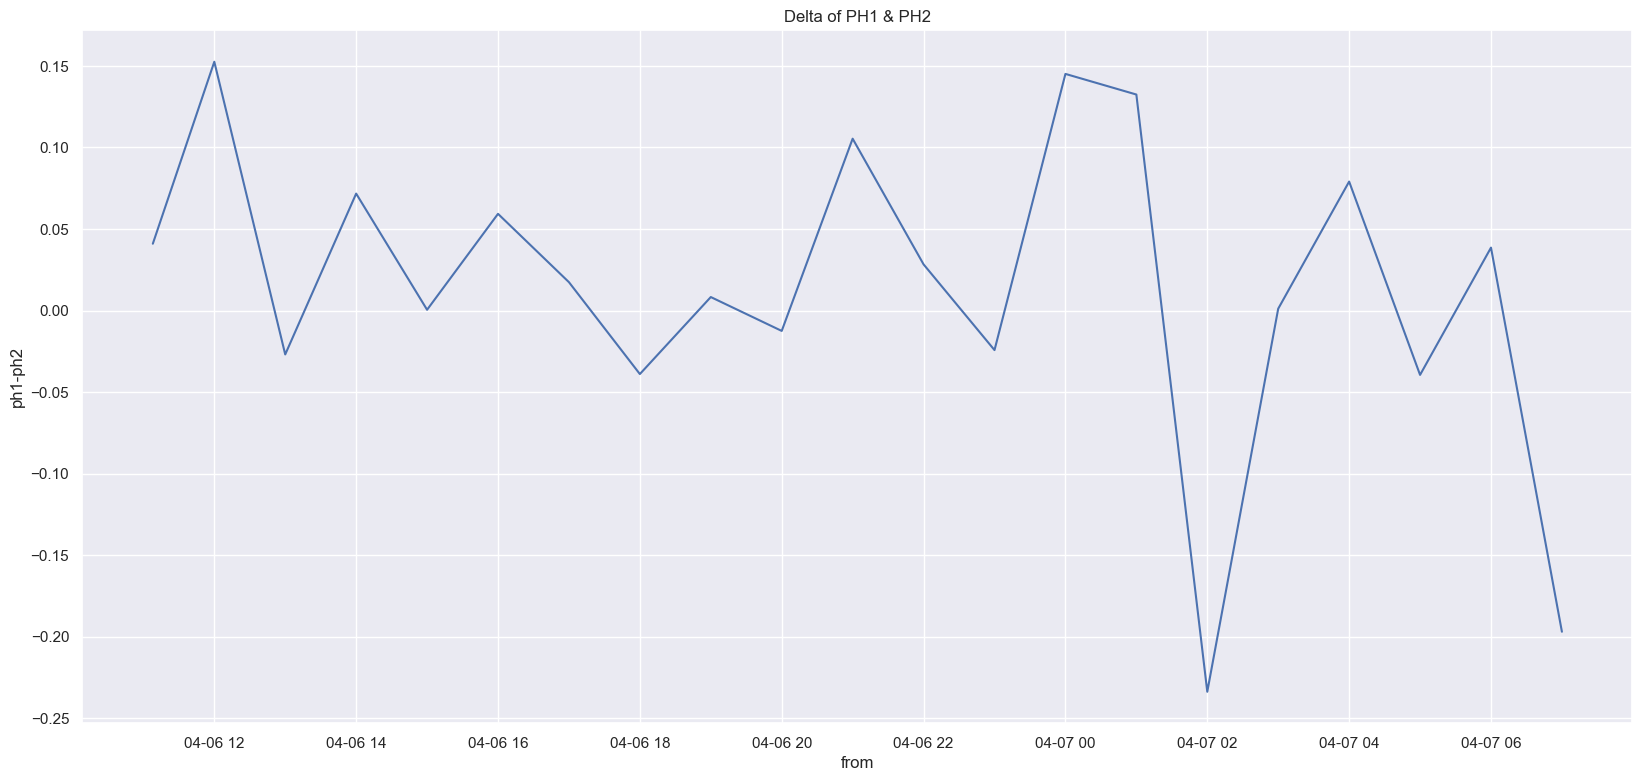

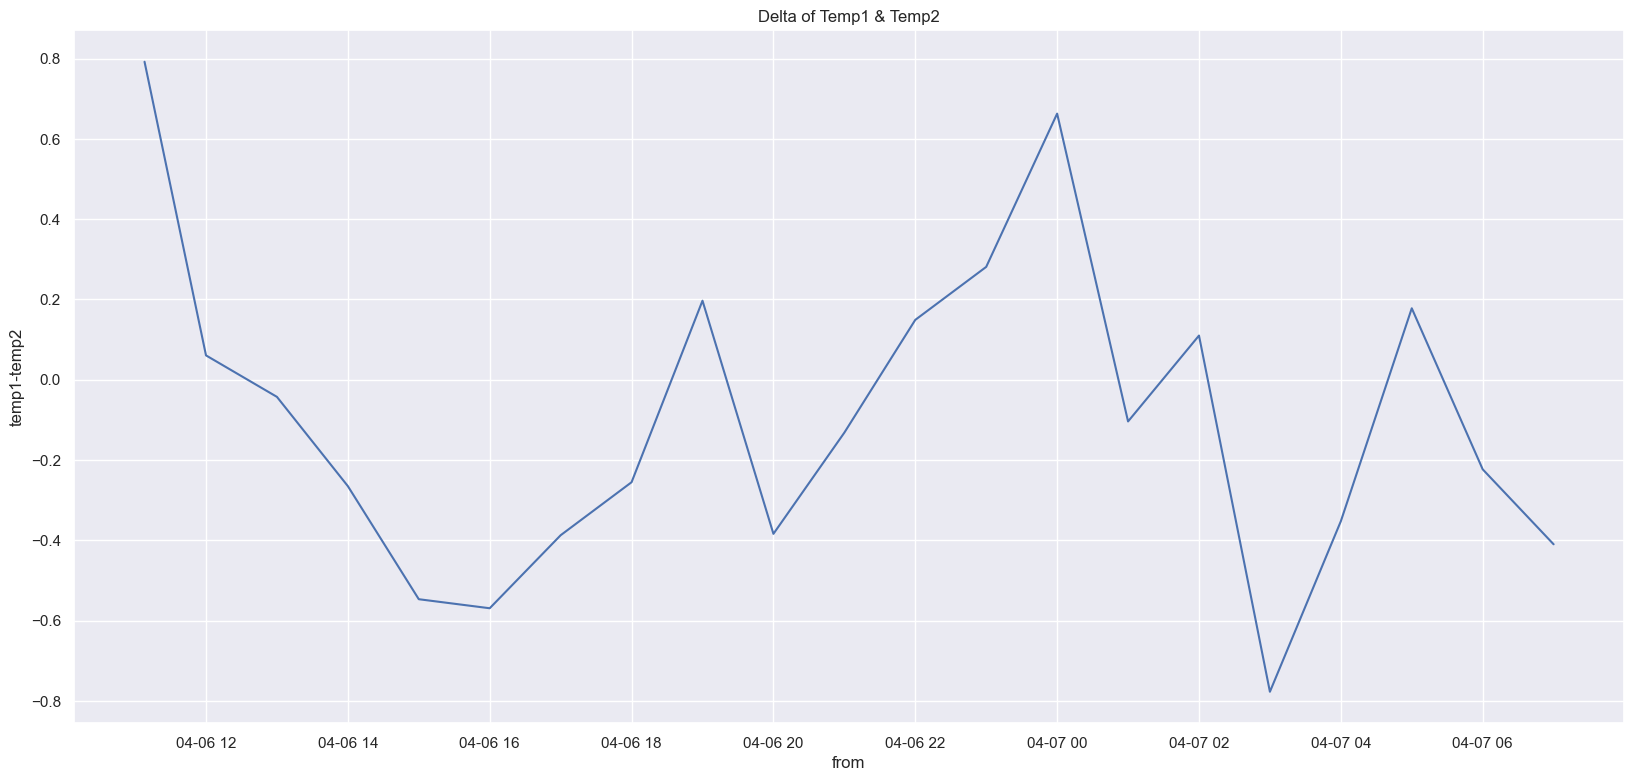

In [ ]:
make_report("BP400E0101", granularity="hourly")

## Solving this in good old SQL

Now I know a lot more about this data and have a pretty clear picture in my head about the structure of a generalized relational database (for this use case). I imagine something like the below architecture for the db

![](database_uml.jpg)

Where `v_metadata`, `v_sensor_data` and `v_sensors_all` are PQSL views, the latter of which could become a materialized view if needed because of performance.